In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator



from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_addons as tfa
from keras.callbacks import ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam


In [2]:
TRAIN_DIR = '../../../data/cell_type/training'
TEST_DIR = '../../../data/cell_type/testing'
VAL_DIR = '../../../data/cell_type/validation'
# INPUT_WIDTH = 27
# INPUT_HEIGHT = 27

BATCH_SIZE = 64
IMG_SIZE = (32, 32)


train_dataset = image_dataset_from_directory(TRAIN_DIR,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             interpolation='bilinear',
                                             label_mode='categorical'
                                            )

validation_dataset = image_dataset_from_directory(VAL_DIR,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  interpolation='bilinear',
                                                  label_mode='categorical'
                                            )

test_dataset = image_dataset_from_directory(TEST_DIR,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  interpolation='bilinear',
                                                  label_mode='categorical'
                                            )

Found 7915 files belonging to 4 classes.
Found 990 files belonging to 4 classes.
Found 991 files belonging to 4 classes.


In [3]:
def get_class_name(class_num):
    if class_num == 0:
        return 'fibroblast'
    elif class_num == 1:
        return 'inflammatory'
    elif class_num == 2:
        return 'epithelial'
    else:
        return 'others'

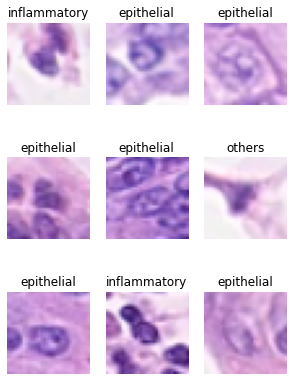

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(5, 7))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(get_class_name(tf.where(tf.equal(labels[i], 1)).numpy()[0][0]))
        plt.axis("off")

In [5]:
train_dataset.class_names

['0', '1', '2', '3']

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

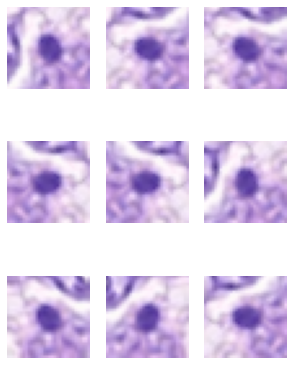

In [8]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(5, 7))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0])
        plt.axis('off')

In [9]:
# preprocess_input = tf.keras.applications.ResNet101V2.preprocess_input

In [10]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None)

In [11]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

In [13]:
prediction_layer = tf.keras.layers.Dense(4)
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

In [14]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
# x = preprocess_input(x)
x = base_model(x, training=True)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [15]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [16]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=6, min_lr=0.5e-15)
adam = Adam(lr=0.00006, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1.0e-6,amsgrad=False)


/home/trungngo/Desktop/venv/colon-cancer-classification/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', f1_score ,precision_m, recall_m])

In [18]:
len(model.trainable_variables)

28

In [19]:
epochs = 500

loss0, accuracy0, f1_0, precision0, recall0 = model.evaluate(validation_dataset)

16/16 [==============================] - 2s 12ms/step - loss: 1.3863 - accuracy: 0.1909 - f1_score: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00


In [20]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.39
initial accuracy: 0.19


In [21]:
import time
start_time = time.time()

In [22]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset,
#                     callbacks=[lr_reducer]
                   )

Epoch 1/500
124/124 [==============================] - 3s 14ms/step - loss: 1.1868 - accuracy: 0.4507 - f1_score: 0.3712 - precision_m: 0.5144 - recall_m: 0.3234 - val_loss: 1.0583 - val_accuracy: 0.5263 - val_f1_score: 0.4905 - val_precision_m: 0.5820 - val_recall_m: 0.4247
Epoch 2/500
124/124 [==============================] - 1s 11ms/step - loss: 0.9887 - accuracy: 0.5625 - f1_score: 0.5436 - precision_m: 0.5778 - recall_m: 0.5234 - val_loss: 0.9210 - val_accuracy: 0.5919 - val_f1_score: 0.5683 - val_precision_m: 0.5754 - val_recall_m: 0.5629
Epoch 3/500
124/124 [==============================] - 1s 11ms/step - loss: 0.9548 - accuracy: 0.5894 - f1_score: 0.5671 - precision_m: 0.5803 - recall_m: 0.5891 - val_loss: 0.9226 - val_accuracy: 0.6000 - val_f1_score: 0.5717 - val_precision_m: 0.6711 - val_recall_m: 0.4992
Epoch 4/500
124/124 [==============================] - 1s 11ms/step - loss: 0.9062 - accuracy: 0.6051 - f1_score: 0.6089 - precision_m: 0.5568 - recall_m: 0.6818 - val_loss

Epoch 31/500
124/124 [==============================] - 1s 11ms/step - loss: 0.4962 - accuracy: 0.8112 - f1_score: 0.7456 - precision_m: 0.6370 - recall_m: 0.9020 - val_loss: 0.5148 - val_accuracy: 0.8030 - val_f1_score: 0.7398 - val_precision_m: 0.6286 - val_recall_m: 0.9004
Epoch 32/500
124/124 [==============================] - 1s 11ms/step - loss: 0.4767 - accuracy: 0.8230 - f1_score: 0.7524 - precision_m: 0.6422 - recall_m: 0.9102 - val_loss: 0.5248 - val_accuracy: 0.8040 - val_f1_score: 0.7553 - val_precision_m: 0.6534 - val_recall_m: 0.8962
Epoch 33/500
124/124 [==============================] - 1s 11ms/step - loss: 0.4872 - accuracy: 0.8173 - f1_score: 0.7418 - precision_m: 0.6297 - recall_m: 0.9064 - val_loss: 0.5418 - val_accuracy: 0.8101 - val_f1_score: 0.7524 - val_precision_m: 0.6539 - val_recall_m: 0.8874
Epoch 34/500
124/124 [==============================] - 1s 11ms/step - loss: 0.4829 - accuracy: 0.8229 - f1_score: 0.7496 - precision_m: 0.6414 - recall_m: 0.9044 - val_

Epoch 61/500
124/124 [==============================] - 1s 11ms/step - loss: 0.3530 - accuracy: 0.8678 - f1_score: 0.7512 - precision_m: 0.6247 - recall_m: 0.9434 - val_loss: 0.5027 - val_accuracy: 0.8263 - val_f1_score: 0.7243 - val_precision_m: 0.5982 - val_recall_m: 0.9184
Epoch 62/500
124/124 [==============================] - 1s 11ms/step - loss: 0.3354 - accuracy: 0.8786 - f1_score: 0.7513 - precision_m: 0.6224 - recall_m: 0.9494 - val_loss: 0.5045 - val_accuracy: 0.8192 - val_f1_score: 0.7260 - val_precision_m: 0.6042 - val_recall_m: 0.9102
Epoch 63/500
124/124 [==============================] - 1s 11ms/step - loss: 0.3383 - accuracy: 0.8778 - f1_score: 0.7421 - precision_m: 0.6101 - recall_m: 0.9495 - val_loss: 0.5221 - val_accuracy: 0.8212 - val_f1_score: 0.7346 - val_precision_m: 0.6202 - val_recall_m: 0.9028
Epoch 64/500
124/124 [==============================] - 1s 11ms/step - loss: 0.3390 - accuracy: 0.8740 - f1_score: 0.7504 - precision_m: 0.6217 - recall_m: 0.9481 - val_

Epoch 91/500
124/124 [==============================] - 1s 11ms/step - loss: 0.2061 - accuracy: 0.9261 - f1_score: 0.7738 - precision_m: 0.6404 - recall_m: 0.9790 - val_loss: 0.6988 - val_accuracy: 0.8010 - val_f1_score: 0.7201 - val_precision_m: 0.5987 - val_recall_m: 0.9038
Epoch 92/500
124/124 [==============================] - 1s 11ms/step - loss: 0.1931 - accuracy: 0.9332 - f1_score: 0.7856 - precision_m: 0.6548 - recall_m: 0.9835 - val_loss: 0.6983 - val_accuracy: 0.8030 - val_f1_score: 0.7057 - val_precision_m: 0.5801 - val_recall_m: 0.9020
Epoch 93/500
124/124 [==============================] - 1s 11ms/step - loss: 0.1957 - accuracy: 0.9292 - f1_score: 0.7762 - precision_m: 0.6425 - recall_m: 0.9822 - val_loss: 0.5816 - val_accuracy: 0.8273 - val_f1_score: 0.7280 - val_precision_m: 0.6065 - val_recall_m: 0.9115
Epoch 94/500
124/124 [==============================] - 1s 11ms/step - loss: 0.1718 - accuracy: 0.9406 - f1_score: 0.7931 - precision_m: 0.6646 - recall_m: 0.9851 - val_

124/124 [==============================] - 1s 11ms/step - loss: 0.1206 - accuracy: 0.9569 - f1_score: 0.8282 - precision_m: 0.7119 - recall_m: 0.9918 - val_loss: 0.7652 - val_accuracy: 0.8101 - val_f1_score: 0.7240 - val_precision_m: 0.6083 - val_recall_m: 0.8952
Epoch 121/500
124/124 [==============================] - 1s 11ms/step - loss: 0.1048 - accuracy: 0.9613 - f1_score: 0.8254 - precision_m: 0.7068 - recall_m: 0.9937 - val_loss: 0.8191 - val_accuracy: 0.8202 - val_f1_score: 0.7608 - val_precision_m: 0.6584 - val_recall_m: 0.9020
Epoch 122/500
124/124 [==============================] - 2s 12ms/step - loss: 0.0938 - accuracy: 0.9677 - f1_score: 0.8415 - precision_m: 0.7301 - recall_m: 0.9946 - val_loss: 0.7939 - val_accuracy: 0.8111 - val_f1_score: 0.7634 - val_precision_m: 0.6602 - val_recall_m: 0.9061
Epoch 123/500
124/124 [==============================] - 2s 12ms/step - loss: 0.1031 - accuracy: 0.9598 - f1_score: 0.8407 - precision_m: 0.7283 - recall_m: 0.9955 - val_loss: 0.87

124/124 [==============================] - 1s 11ms/step - loss: 0.0765 - accuracy: 0.9732 - f1_score: 0.8593 - precision_m: 0.7567 - recall_m: 0.9956 - val_loss: 0.8826 - val_accuracy: 0.8121 - val_f1_score: 0.7463 - val_precision_m: 0.6373 - val_recall_m: 0.9011
Epoch 150/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0616 - accuracy: 0.9792 - f1_score: 0.8646 - precision_m: 0.7641 - recall_m: 0.9974 - val_loss: 0.9067 - val_accuracy: 0.8111 - val_f1_score: 0.7438 - val_precision_m: 0.6327 - val_recall_m: 0.9025
Epoch 151/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0642 - accuracy: 0.9771 - f1_score: 0.8589 - precision_m: 0.7556 - recall_m: 0.9968 - val_loss: 0.9559 - val_accuracy: 0.8051 - val_f1_score: 0.7493 - val_precision_m: 0.6414 - val_recall_m: 0.9021
Epoch 152/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0610 - accuracy: 0.9783 - f1_score: 0.8622 - precision_m: 0.7597 - recall_m: 0.9977 - val_loss: 0.98

124/124 [==============================] - 1s 11ms/step - loss: 0.0425 - accuracy: 0.9853 - f1_score: 0.8954 - precision_m: 0.8124 - recall_m: 0.9984 - val_loss: 1.1538 - val_accuracy: 0.8162 - val_f1_score: 0.7827 - val_precision_m: 0.6991 - val_recall_m: 0.8900
Epoch 179/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0531 - accuracy: 0.9822 - f1_score: 0.8923 - precision_m: 0.8080 - recall_m: 0.9975 - val_loss: 1.0519 - val_accuracy: 0.8111 - val_f1_score: 0.7601 - val_precision_m: 0.6638 - val_recall_m: 0.8895
Epoch 180/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0500 - accuracy: 0.9824 - f1_score: 0.8979 - precision_m: 0.8170 - recall_m: 0.9977 - val_loss: 1.0022 - val_accuracy: 0.8263 - val_f1_score: 0.7842 - val_precision_m: 0.6985 - val_recall_m: 0.8949
Epoch 181/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0472 - accuracy: 0.9841 - f1_score: 0.8981 - precision_m: 0.8174 - recall_m: 0.9976 - val_loss: 1.20

124/124 [==============================] - 1s 11ms/step - loss: 0.0500 - accuracy: 0.9846 - f1_score: 0.8935 - precision_m: 0.8095 - recall_m: 0.9985 - val_loss: 1.1390 - val_accuracy: 0.8010 - val_f1_score: 0.7537 - val_precision_m: 0.6594 - val_recall_m: 0.8805
Epoch 208/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0443 - accuracy: 0.9856 - f1_score: 0.8718 - precision_m: 0.7749 - recall_m: 0.9982 - val_loss: 1.0912 - val_accuracy: 0.8091 - val_f1_score: 0.7496 - val_precision_m: 0.6483 - val_recall_m: 0.8895
Epoch 209/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0379 - accuracy: 0.9858 - f1_score: 0.8984 - precision_m: 0.8172 - recall_m: 0.9989 - val_loss: 1.1268 - val_accuracy: 0.8212 - val_f1_score: 0.7756 - val_precision_m: 0.6875 - val_recall_m: 0.8902
Epoch 210/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0473 - accuracy: 0.9843 - f1_score: 0.9137 - precision_m: 0.8429 - recall_m: 0.9984 - val_loss: 1.13

124/124 [==============================] - 1s 11ms/step - loss: 0.0373 - accuracy: 0.9881 - f1_score: 0.8977 - precision_m: 0.8170 - recall_m: 0.9986 - val_loss: 1.1975 - val_accuracy: 0.8263 - val_f1_score: 0.7941 - val_precision_m: 0.7159 - val_recall_m: 0.8922
Epoch 237/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0342 - accuracy: 0.9872 - f1_score: 0.9164 - precision_m: 0.8473 - recall_m: 0.9987 - val_loss: 1.0449 - val_accuracy: 0.8242 - val_f1_score: 0.7818 - val_precision_m: 0.6900 - val_recall_m: 0.9028
Epoch 238/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0312 - accuracy: 0.9890 - f1_score: 0.9192 - precision_m: 0.8519 - recall_m: 0.9991 - val_loss: 1.0855 - val_accuracy: 0.8212 - val_f1_score: 0.7875 - val_precision_m: 0.6966 - val_recall_m: 0.9070
Epoch 239/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0292 - accuracy: 0.9912 - f1_score: 0.9064 - precision_m: 0.8306 - recall_m: 0.9986 - val_loss: 1.07

124/124 [==============================] - 1s 11ms/step - loss: 0.0344 - accuracy: 0.9874 - f1_score: 0.9083 - precision_m: 0.8340 - recall_m: 0.9986 - val_loss: 1.0745 - val_accuracy: 0.8182 - val_f1_score: 0.7979 - val_precision_m: 0.7181 - val_recall_m: 0.8984
Epoch 266/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0300 - accuracy: 0.9888 - f1_score: 0.9209 - precision_m: 0.8553 - recall_m: 0.9989 - val_loss: 1.0427 - val_accuracy: 0.8081 - val_f1_score: 0.7699 - val_precision_m: 0.6805 - val_recall_m: 0.8879
Epoch 267/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0265 - accuracy: 0.9913 - f1_score: 0.9236 - precision_m: 0.8594 - recall_m: 0.9990 - val_loss: 1.1130 - val_accuracy: 0.8333 - val_f1_score: 0.7977 - val_precision_m: 0.7155 - val_recall_m: 0.9021
Epoch 268/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0263 - accuracy: 0.9917 - f1_score: 0.9145 - precision_m: 0.8440 - recall_m: 0.9989 - val_loss: 1.20

124/124 [==============================] - 1s 11ms/step - loss: 0.0240 - accuracy: 0.9922 - f1_score: 0.9290 - precision_m: 0.8690 - recall_m: 0.9990 - val_loss: 1.0919 - val_accuracy: 0.8192 - val_f1_score: 0.7768 - val_precision_m: 0.6937 - val_recall_m: 0.8829
Epoch 295/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0318 - accuracy: 0.9901 - f1_score: 0.9085 - precision_m: 0.8346 - recall_m: 0.9985 - val_loss: 1.0630 - val_accuracy: 0.8141 - val_f1_score: 0.7705 - val_precision_m: 0.6850 - val_recall_m: 0.8822
Epoch 296/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0254 - accuracy: 0.9904 - f1_score: 0.9274 - precision_m: 0.8661 - recall_m: 0.9991 - val_loss: 1.2651 - val_accuracy: 0.8091 - val_f1_score: 0.7874 - val_precision_m: 0.7160 - val_recall_m: 0.8753
Epoch 297/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0203 - accuracy: 0.9934 - f1_score: 0.9411 - precision_m: 0.8896 - recall_m: 0.9996 - val_loss: 1.24

124/124 [==============================] - 1s 11ms/step - loss: 0.0226 - accuracy: 0.9934 - f1_score: 0.9130 - precision_m: 0.8414 - recall_m: 0.9992 - val_loss: 1.0759 - val_accuracy: 0.8323 - val_f1_score: 0.7942 - val_precision_m: 0.7157 - val_recall_m: 0.8929
Epoch 324/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0163 - accuracy: 0.9952 - f1_score: 0.9306 - precision_m: 0.8718 - recall_m: 0.9995 - val_loss: 1.0757 - val_accuracy: 0.8202 - val_f1_score: 0.7694 - val_precision_m: 0.6751 - val_recall_m: 0.8950
Epoch 325/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0169 - accuracy: 0.9946 - f1_score: 0.9403 - precision_m: 0.8886 - recall_m: 0.9994 - val_loss: 1.0329 - val_accuracy: 0.8182 - val_f1_score: 0.7801 - val_precision_m: 0.6925 - val_recall_m: 0.8946
Epoch 326/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0305 - accuracy: 0.9910 - f1_score: 0.9132 - precision_m: 0.8424 - recall_m: 0.9982 - val_loss: 1.32

124/124 [==============================] - 1s 11ms/step - loss: 0.0236 - accuracy: 0.9924 - f1_score: 0.9375 - precision_m: 0.8838 - recall_m: 0.9991 - val_loss: 1.0796 - val_accuracy: 0.8202 - val_f1_score: 0.7826 - val_precision_m: 0.7018 - val_recall_m: 0.8855
Epoch 353/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0284 - accuracy: 0.9896 - f1_score: 0.9174 - precision_m: 0.8493 - recall_m: 0.9986 - val_loss: 1.0962 - val_accuracy: 0.8253 - val_f1_score: 0.7634 - val_precision_m: 0.6739 - val_recall_m: 0.8812
Epoch 354/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0207 - accuracy: 0.9929 - f1_score: 0.9324 - precision_m: 0.8751 - recall_m: 0.9989 - val_loss: 1.1979 - val_accuracy: 0.8091 - val_f1_score: 0.7477 - val_precision_m: 0.6546 - val_recall_m: 0.8724
Epoch 355/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0233 - accuracy: 0.9923 - f1_score: 0.9149 - precision_m: 0.8453 - recall_m: 0.9981 - val_loss: 1.26

124/124 [==============================] - 1s 11ms/step - loss: 0.0277 - accuracy: 0.9925 - f1_score: 0.9034 - precision_m: 0.8259 - recall_m: 0.9991 - val_loss: 1.0740 - val_accuracy: 0.8121 - val_f1_score: 0.7490 - val_precision_m: 0.6450 - val_recall_m: 0.8940
Epoch 382/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0274 - accuracy: 0.9908 - f1_score: 0.9011 - precision_m: 0.8218 - recall_m: 0.9989 - val_loss: 1.1238 - val_accuracy: 0.8222 - val_f1_score: 0.7827 - val_precision_m: 0.6977 - val_recall_m: 0.8921
Epoch 383/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0150 - accuracy: 0.9952 - f1_score: 0.9281 - precision_m: 0.8667 - recall_m: 0.9999 - val_loss: 1.1627 - val_accuracy: 0.8273 - val_f1_score: 0.7861 - val_precision_m: 0.7025 - val_recall_m: 0.8930
Epoch 384/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0106 - accuracy: 0.9961 - f1_score: 0.9273 - precision_m: 0.8657 - recall_m: 0.9996 - val_loss: 1.27

124/124 [==============================] - 1s 11ms/step - loss: 0.0192 - accuracy: 0.9933 - f1_score: 0.8962 - precision_m: 0.8132 - recall_m: 0.9995 - val_loss: 1.1304 - val_accuracy: 0.8131 - val_f1_score: 0.7543 - val_precision_m: 0.6507 - val_recall_m: 0.8986
Epoch 411/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0097 - accuracy: 0.9963 - f1_score: 0.9092 - precision_m: 0.8347 - recall_m: 0.9999 - val_loss: 1.2845 - val_accuracy: 0.8293 - val_f1_score: 0.7994 - val_precision_m: 0.7195 - val_recall_m: 0.9001
Epoch 412/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0143 - accuracy: 0.9946 - f1_score: 0.9197 - precision_m: 0.8522 - recall_m: 0.9999 - val_loss: 1.3721 - val_accuracy: 0.8263 - val_f1_score: 0.7989 - val_precision_m: 0.7221 - val_recall_m: 0.8952
Epoch 413/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0269 - accuracy: 0.9924 - f1_score: 0.8951 - precision_m: 0.8132 - recall_m: 0.9982 - val_loss: 1.08

124/124 [==============================] - 1s 11ms/step - loss: 0.0204 - accuracy: 0.9929 - f1_score: 0.8810 - precision_m: 0.7887 - recall_m: 0.9992 - val_loss: 1.2282 - val_accuracy: 0.8061 - val_f1_score: 0.7561 - val_precision_m: 0.6603 - val_recall_m: 0.8851
Epoch 440/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0154 - accuracy: 0.9960 - f1_score: 0.9400 - precision_m: 0.8882 - recall_m: 0.9991 - val_loss: 1.3602 - val_accuracy: 0.8313 - val_f1_score: 0.7990 - val_precision_m: 0.7235 - val_recall_m: 0.8932
Epoch 441/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0311 - accuracy: 0.9891 - f1_score: 0.8883 - precision_m: 0.8041 - recall_m: 0.9990 - val_loss: 1.0702 - val_accuracy: 0.8323 - val_f1_score: 0.7030 - val_precision_m: 0.5732 - val_recall_m: 0.9098
Epoch 442/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0208 - accuracy: 0.9941 - f1_score: 0.8400 - precision_m: 0.7259 - recall_m: 0.9989 - val_loss: 1.24

124/124 [==============================] - 1s 11ms/step - loss: 0.0064 - accuracy: 0.9977 - f1_score: 0.9271 - precision_m: 0.8647 - recall_m: 1.0000 - val_loss: 1.5162 - val_accuracy: 0.8253 - val_f1_score: 0.7861 - val_precision_m: 0.7090 - val_recall_m: 0.8829
Epoch 469/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0205 - accuracy: 0.9938 - f1_score: 0.9148 - precision_m: 0.8446 - recall_m: 0.9996 - val_loss: 1.2011 - val_accuracy: 0.8131 - val_f1_score: 0.7705 - val_precision_m: 0.6759 - val_recall_m: 0.8972
Epoch 470/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0151 - accuracy: 0.9960 - f1_score: 0.9231 - precision_m: 0.8584 - recall_m: 0.9995 - val_loss: 1.3255 - val_accuracy: 0.8283 - val_f1_score: 0.7975 - val_precision_m: 0.7209 - val_recall_m: 0.8929
Epoch 471/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0133 - accuracy: 0.9955 - f1_score: 0.9081 - precision_m: 0.8337 - recall_m: 0.9996 - val_loss: 1.24

124/124 [==============================] - 1s 11ms/step - loss: 0.0098 - accuracy: 0.9966 - f1_score: 0.9426 - precision_m: 0.8922 - recall_m: 0.9999 - val_loss: 1.3849 - val_accuracy: 0.8091 - val_f1_score: 0.7783 - val_precision_m: 0.6958 - val_recall_m: 0.8845
Epoch 498/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0437 - accuracy: 0.9867 - f1_score: 0.9055 - precision_m: 0.8328 - recall_m: 0.9972 - val_loss: 1.0745 - val_accuracy: 0.8263 - val_f1_score: 0.7762 - val_precision_m: 0.6935 - val_recall_m: 0.8824
Epoch 499/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0169 - accuracy: 0.9941 - f1_score: 0.9406 - precision_m: 0.8893 - recall_m: 0.9990 - val_loss: 1.4356 - val_accuracy: 0.8192 - val_f1_score: 0.7890 - val_precision_m: 0.7174 - val_recall_m: 0.8774
Epoch 500/500
124/124 [==============================] - 1s 11ms/step - loss: 0.0102 - accuracy: 0.9968 - f1_score: 0.9526 - precision_m: 0.9107 - recall_m: 0.9994 - val_loss: 1.53

In [23]:
print("---  Training time in seconds ---%s " % (time.time() - start_time))

---  Training time in seconds ---698.1378817558289 


In [24]:
loss, accuracy, f1_score, precision, recall = model.evaluate(test_dataset)

16/16 [==============================] - 0s 11ms/step - loss: 1.6463 - accuracy: 0.8214 - f1_score: 0.7979 - precision_m: 0.7285 - recall_m: 0.8825


In [25]:
model.save('VGG16-before-using-extraData.hdf5')

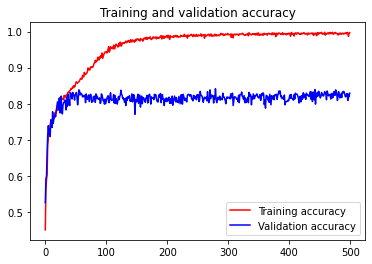

<Figure size 432x288 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

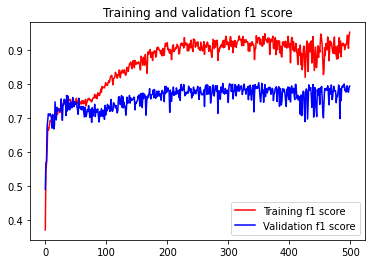

<Figure size 432x288 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt
f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']

epochs = range(len(f1))

plt.plot(epochs, f1, 'r', label='Training f1 score')
plt.plot(epochs, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
plt.legend(loc=0)
plt.figure()


plt.show()

In [27]:
print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('Test F1 score', f1_score)

Test loss: 1.6462786197662354
Test accuracy: 0.8213925361633301
Test F1 score 0.7978865504264832


In [29]:
print('Max Test accuracy:', max(history.history['val_accuracy']))

Max Test accuracy: 0.8043350577354431
